![img](./img/7744536-636aa1632b489f73.png)

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
#载入数据
data = pd.read_csv('cs-training.csv')

In [2]:
#处理缺失值
print(data.columns)
import numpy as np
from sklearn.ensemble import RandomForestRegressor

def set_missing(df, col, method_type='mean', new_col_suffix='_filled'):
    """
    通用方法处理异常值或缺失值。
    :param df: 输入的 Pandas DataFrame
    :param col: 需要处理的列名
    :param method_type: 填充方法类型，支持 'mean' 和 'randomforest'
    :param new_col_suffix: 新列后缀名，默认 '_filled'
    :return: 新的 DataFrame，增加一个新的列存储填充后的数据
    """
    # 检查列是否在 DataFrame 中
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in the DataFrame.")
    
    # 创建新列名
    new_col_name = f"{col}{new_col_suffix}"
    
    if method_type == 'mean':
        # 基于均值填充
        mean_value = df[col].mean()
        df[new_col_name] = df[col].fillna(mean_value)
    
    elif method_type == 'randomforest':
        # 检查是否有缺失值
        if df[col].isnull().sum() == 0:
            df[new_col_name] = df[col]
            print(f"No missing values found in column '{col}'. No need to use RandomForest.")
            return df

        # 将数据分为缺失值部分和非缺失值部分
        df_not_null = df[df[col].notnull()]
        df_null = df[df[col].isnull()]

        # 准备特征和目标列
        features = df.drop(columns=[col])
        features_not_null = df_not_null.drop(columns=[col])
        features_null = df_null.drop(columns=[col])

        # 检查是否有足够的特征进行预测
        if features_not_null.shape[1] == 0:
            raise ValueError("Not enough features to use RandomForest for filling missing values.")

        # 随机森林训练
        rf = RandomForestRegressor(random_state=42, n_estimators=100)
        rf.fit(features_not_null, df_not_null[col])

        # 预测缺失值
        predicted_values = rf.predict(features_null)

        # 填充缺失值
        df.loc[df[col].isnull(), new_col_name] = predicted_values
        df.loc[df[col].notnull(), new_col_name] = df[col]
    
    else:
        raise ValueError(f"Invalid method_type '{method_type}'. Supported methods are 'mean' and 'randomforest'.")

    return df


df_fill = set_missing(data, col="MonthlyIncome",method_type="mean")    

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')


In [3]:
#对NumberOfDependents的缺失值进行异常处理
df_fill = set_missing(df_fill, col="NumberOfDependents",method_type="mean")

In [4]:
#drop掉NumberOfDependents和MonthlyIncome
colums_to_drop = ["NumberOfDependents", "MonthlyIncome"]
df_drop = df_fill.drop(colums_to_drop, axis=1)

In [5]:
#数据探索EDA
#进行重命名
new_columns_name_dict = {"SeriousDlqin2yrs":"是否违约用户", 
                         "RevolvingUtilizationOfUnsecuredLines":"信贷额度的循环使用率",
                         "age":"年龄", 
                         "NumberOfTime30-59DaysPastDueNotWorse":"30-59天逾期次数",
                         "DebtRatio":"债务收入比", 
                         "NumberOfOpenCreditLinesAndLoans":"贷款总数",
                         "NumberOfTimes90DaysLate":"90天以上逾期次数", 
                         "NumberRealEstateLoansOrLines":"房地产或信贷数", 
                         "NumberOfTime60-89DaysPastDueNotWorse":"60-90天逾期次数",
                          "MonthlyIncome_filled":"月收入", 
                         "NumberOfDependents_filled":"家庭人数"}
df_renamed = df_drop.rename(columns=new_columns_name_dict)


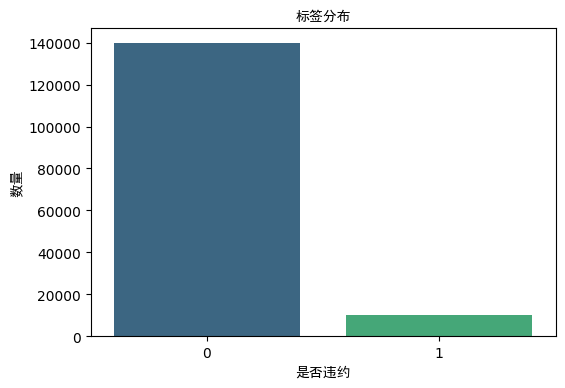

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager


# 指定字体路径
font_path = "SimHei.ttf"


# 设置字体属性
prop = font_manager.FontProperties(fname=font_path)


plt.figure(figsize=(6, 4))  # 设置图形大小
sns.countplot(x='是否违约用户', data=df_renamed, palette="viridis")  # 绘制直方图
plt.title("标签分布",fontproperties=prop)  # 设置标题
plt.xlabel("是否违约",fontproperties=prop)  # X轴标签
plt.ylabel("数量",fontproperties=prop)  # Y轴标签
plt.show()

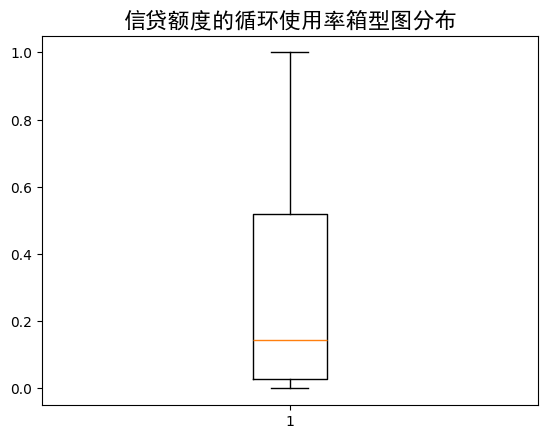

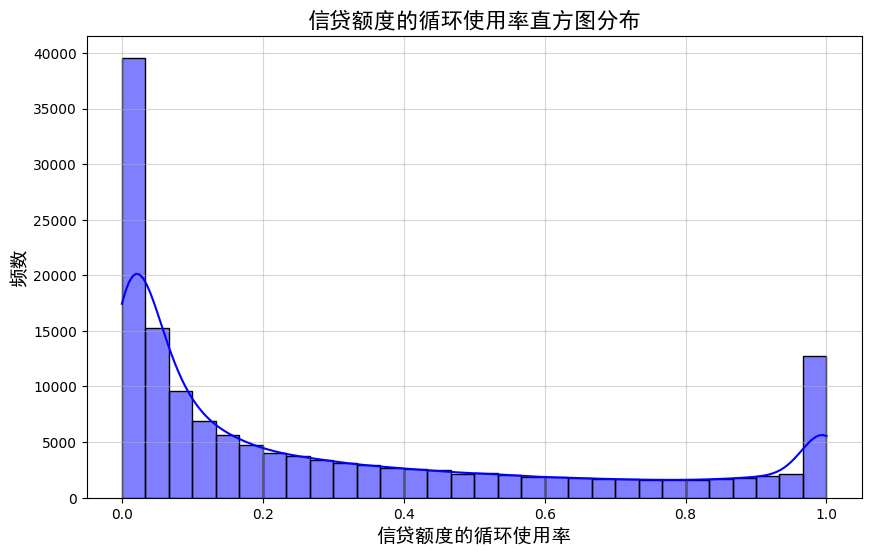

In [7]:
df_renamed_filter = df_renamed[df_renamed['信贷额度的循环使用率']<=1]

def plot_feature(df, feature, bins, prop):
    # 设置字体和样式（如需支持中文）
    plt.boxplot(df[feature])
    plt.title('{}箱型图分布'.format(feature), fontproperties=prop,fontsize=16)
    plt.show()
    
    plt.figure(figsize=(10, 6))  # 设置画布大小
    sns.histplot(data=df, x=feature, bins=bins, kde=True, color='blue')  # kde=True 添加密度曲线
    plt.title('{}直方图分布'.format(feature), fontproperties=prop,fontsize=16)
    plt.xlabel('{}'.format(feature), fontproperties=prop, fontsize=14)
    plt.ylabel('频数', fontproperties=prop,fontsize=14)
    plt.grid(alpha=0.5)  # 添加网格
    plt.show()

plot_feature(df_renamed_filter, '信贷额度的循环使用率', 30, prop)

In [8]:
#检测算法的箱型图
df_renamed_filter.describe()
df_renamed_filter = df_renamed_filter[(df_renamed_filter["年龄"]>0) & (df_renamed_filter["60-90天逾期次数"]<90)]
df_renamed_filter.describe()
df = df_renamed_filter
df['是否违约用户']=1-df['是否违约用户']
df.describe()


,是否违约用户,信贷额度的循环使用率,年龄,30-59天逾期次数,债务收入比,贷款总数,90天以上逾期次数,房地产或信贷数,60-90天逾期次数,月收入,家庭人数
count,146409.000000,146409.000000,146409.000000,146409.000000,146409.000000,146409.000000,146409.000000,146409.000000,146409.000000,1.464090e+05,146409.000000
mean,0.940974,0.302498,52.515631,0.228312,356.091560,8.515453,0.078042,1.027731,0.056486,6.700533e+03,0.754268
std,0.235675,0.336877,14.744832,0.665226,2057.676356,5.150571,0.440820,1.132093,0.303015,1.301593e+04,1.098498
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,1.000000,0.028515,42.000000,0.000000,0.175915,5.000000,0.000000,0.000000,0.000000,3.958000e+03,0.000000
50%,1.000000,0.143716,52.000000,0.000000,0.366998,8.000000,0.000000,1.000000,0.000000,6.650000e+03,0.000000
75%,1.000000,0.516929,63.000000,0.000000,0.871876,11.000000,0.000000,2.000000,0.000000,7.434000e+03,1.000000
max,1.000000,1.000000,109.000000,13.000000,329664.000000,58.000000,17.000000,54.000000,11.000000,3.008750e+06,20.000000


In [9]:
#变量选择
from scipy import stats
import pandas as pd
import numpy as np


def calculate_iv_with_dynamic_bucket_merge(df, target, feature, n_bins=20, min_bin_pct=0.01, min_diff=0.01):
    
    if df[target].nunique() != 2:
        raise ValueError("目标变量必须是二分类类型！")

    if feature not in df.columns or target not in df.columns:
        raise ValueError("输入的特征或目标变量在数据集中不存在！")

    # 初始化分箱
    df = df[[feature, target]].copy()
    df['bin'] = pd.qcut(df[feature], q=n_bins, duplicates='drop')

    while True:
        # 计算每个分箱的统计量
        bin_stats = df.groupby('bin').agg(
            total=(target, 'count'),
            bad=(target, 'sum')
        )
        bin_stats['good'] = bin_stats['total'] - bin_stats['bad']
        bin_stats['bad_rate'] = bin_stats['bad'] / bin_stats['total']
        bin_stats['bin_pct'] = bin_stats['total'] / len(df)

        # 检查最小分箱占比是否满足条件
        if bin_stats['bin_pct'].min() < min_bin_pct:
            smallest_bin = bin_stats['bin_pct'].idxmin()
            print("smallest_bin:", smallest_bin)
            df['bin'] = merge_bins(df, smallest_bin, feature)
            continue

        # 检查相邻分箱的坏样本率差异是否满足条件
        bad_rate_diff = bin_stats['bad_rate'].diff().abs()
        if bad_rate_diff.min() < min_diff:
            interval_to_merge = bad_rate_diff.idxmin()  # 获取分箱间隔
            print("interval_to_merge:", interval_to_merge)
            idx_to_merge = list(bin_stats.index).index(interval_to_merge)  # 转换为整数索引
            print(f"Attempting to merge bins at interval: {interval_to_merge}, index: {idx_to_merge}")
            df['bin'] = merge_adjacent_bins(df, idx_to_merge, feature)
            continue

        break

    # 计算WOE和IV
    bin_stats['woe'] = np.log((bin_stats['good'] / bin_stats['good'].sum()) / (bin_stats['bad'] / bin_stats['bad'].sum()))
    bin_stats['iv'] = (bin_stats['good'] / bin_stats['good'].sum() - bin_stats['bad'] / bin_stats['bad'].sum()) * bin_stats['woe']

    # 添加区间信息
    bin_stats['interval'] = [str(interval) for interval in bin_stats.index]
    bin_stats.reset_index(drop=True, inplace=True)

    return bin_stats[['interval', 'total', 'bad', 'good', 'bad_rate', 'bin_pct', 'woe', 'iv']]

def merge_bins(df, smallest_bin, feature):
    bins = df['bin'].cat.categories
    smallest_idx = bins.get_loc(smallest_bin)
    new_bins = list(bins)

    if smallest_idx == 0:
        new_bins[1] = pd.Interval(left=bins[0].left, right=bins[1].right)
        del new_bins[0]
    else:
        new_bins[smallest_idx - 1] = pd.Interval(left=bins[smallest_idx - 1].left, right=bins[smallest_idx].right)
        del new_bins[smallest_idx]

    df['bin'] = pd.cut(df[feature], bins=pd.IntervalIndex(new_bins))
    return df['bin']

def merge_adjacent_bins(df, idx_to_merge, feature):
    bins = df['bin'].cat.categories
    new_bins = list(bins)

    if idx_to_merge == 0 and len(bins) > 1:
        new_bins[1] = pd.Interval(left=bins[0].left, right=bins[1].right)
        del new_bins[0]
    elif 0 < idx_to_merge < len(bins) - 1:
        new_bins[idx_to_merge - 1] = pd.Interval(left=bins[idx_to_merge - 1].left, right=bins[idx_to_merge].right)
        del new_bins[idx_to_merge]
    elif idx_to_merge == len(bins) - 1 and len(bins) > 1:
        new_bins[-2] = pd.Interval(left=bins[-2].left, right=bins[-1].right)
        del new_bins[-1]
    else:
        raise IndexError(f"Invalid index for merging: {idx_to_merge}")

    # 更新分箱区间
    df['bin'] = pd.cut(df[feature], bins=pd.IntervalIndex(new_bins))
    return df['bin']

# 合并最小分箱占比的辅助函数
def merge_bins(df, smallest_bin, feature):
    bins = df['bin'].cat.categories
    smallest_idx = bins.get_loc(smallest_bin)
    new_bins = list(bins)

    if smallest_idx == 0:
        new_bins[1] = pd.Interval(left=bins[0].left, right=bins[1].right)
        del new_bins[0]
    else:
        new_bins[smallest_idx - 1] = pd.Interval(left=bins[smallest_idx - 1].left, right=bins[smallest_idx].right)
        del new_bins[smallest_idx]

    df['bin'] = pd.cut(df[feature], bins=pd.IntervalIndex(new_bins))
    return df['bin']

# 合并相邻分箱的辅助函数
def merge_adjacent_bins(df, idx_to_merge, feature):
    bins = df['bin'].cat.categories
    new_bins = list(bins)

    if idx_to_merge == 0 and len(bins) > 1:
        new_bins[1] = pd.Interval(left=bins[0].left, right=bins[1].right)
        del new_bins[0]
    elif 0 < idx_to_merge < len(bins) - 1:
        new_bins[idx_to_merge - 1] = pd.Interval(left=bins[idx_to_merge - 1].left, right=bins[idx_to_merge].right)
        del new_bins[idx_to_merge]
    elif idx_to_merge == len(bins) - 1 and len(bins) > 1:
        new_bins[-2] = pd.Interval(left=bins[-2].left, right=bins[-1].right)
        del new_bins[-1]
    else:
        raise IndexError(f"Invalid index for merging: {idx_to_merge}")

    df['bin'] = pd.cut(df[feature], bins=pd.IntervalIndex(new_bins))
    return df['bin']


# feature_plot(df, feature="90天以上逾期次数", bins=10)
# print(df[df['是否违约用户']==0]['90天以上逾期次数'].value_counts())
bin_stats = calculate_iv_with_dynamic_bucket_merge(df, target='是否违约用户', feature="债务收入比", n_bins=10, min_bin_pct=0.05, min_diff=0.01)
print(bin_stats)



interval_to_merge: (0.288, 0.367]
Attempting to merge bins at interval: (0.288, 0.367], index: 4
interval_to_merge: (0.214, 0.367]
Attempting to merge bins at interval: (0.214, 0.367], index: 3
interval_to_merge: (1287.0, 329664.0]
Attempting to merge bins at interval: (1287.0, 329664.0], index: 7
interval_to_merge: (0.135, 0.367]
Attempting to merge bins at interval: (0.135, 0.367], index: 2
interval_to_merge: (0.0312, 0.367]
Attempting to merge bins at interval: (0.0312, 0.367], index: 1
          interval  total    bad  good  bad_rate   bin_pct       woe        iv
0  (-0.001, 0.367]  73205  69520  3685  0.949662  0.500003 -0.168414  0.013172
1   (0.367, 0.468]  14677  13773   904  0.938407  0.100247  0.045294  0.000210
2    (0.468, 0.65]  14613  13489  1124  0.923082  0.099809  0.283949  0.009129
3      (0.65, 4.0]  14639  13122  1517  0.896373  0.099987  0.611374  0.049087
4  (4.0, 329664.0]  29275  27863  1412  0.951768  0.199954 -0.213363  0.008291


********************信贷额度的循环使用率********************
iv值: 0.8804703930744452
********************年龄********************
   min  max    sum  total      rate       woe  goodattribute  badattribute  \
0   21   34  16443  18185  0.904207 -0.524064       0.119354      0.201574   
1   35   40  14050  15288  0.919021 -0.339805       0.101984      0.143254   
2   41   45  14530  15723  0.924124 -0.269185       0.105468      0.138047   
3   46   50  17042  18381  0.927153 -0.225172       0.123702      0.154941   
4   51   54  13200  14135  0.933852 -0.121504       0.095814      0.108193   
5   55   59  15985  16820  0.950357  0.183045       0.116029      0.096621   
6   60   64  16265  16905  0.962141  0.466373       0.118062      0.074057   
7   65   71  14677  15060  0.974568  0.877072       0.106535      0.044318   
8   72  109  15575  15912  0.978821  1.064410       0.113053      0.038996   

         iv  
0  0.043089  
1  0.014024  
2  0.008770  
3  0.007034  
4  0.001504  
5  0.003553  
6  

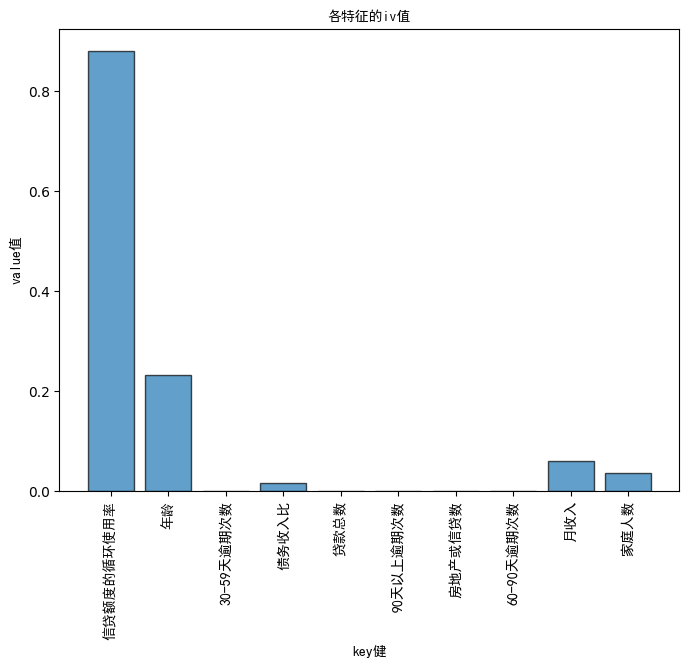

In [21]:
def mono_bin(df, target, feature, bins=20):
    # 提取特征列和目标列
    X = df[feature]
    Y = df[target]
    
    r = 0
    good = Y.sum()  # 好样本数（目标为1的样本）
    bad = Y.count() - good  # 坏样本数（目标为0的样本）
    
    # 初始分箱数量为bin，逐步减少，直到Spearman相关系数接近1
    while np.abs(r) < 1:
        # 使用qcut进行等频分箱
        d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.qcut(X, bins, duplicates='drop')})
        
        # 按分箱分组，计算每个分箱的统计数据
        d2 = d1.groupby('Bucket', as_index=True)
        
        # 计算Spearman秩相关系数
        r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
        
        # 若相关系数较低，减少分箱数
        bins -= 1
    
    # 汇总每个分箱的统计数据
    d3 = pd.DataFrame(d2.X.min(), columns=['min'])
    d3['min'] = d2.min().X
    d3['max'] = d2.max().X
    d3['sum'] = d2.sum().Y
    d3['total'] = d2.count().Y
    d3['rate'] = d2.mean().Y
    d3['woe'] = np.log((d3['rate'] / (1 - d3['rate'])) / (good / bad))
    d3['goodattribute'] = d3['sum'] / good
    d3['badattribute'] = (d3['total'] - d3['sum']) / bad
    d3['iv']  = (d3['goodattribute'] - d3['badattribute']) * d3['woe']
    iv_sum = ((d3['goodattribute'] - d3['badattribute']) * d3['woe']).sum()
    
    # 按照分箱的最小值排序
    d4 = d3.sort_values(by='min').reset_index(drop=True)
    
    
    # 计算分箱的切割点
    cut = [float('-inf')]
    for i in range(1, bins + 1):
        qua = X.quantile(i / (bins + 1))
        cut.append(round(qua, 4))
    cut.append(float('inf'))
    
    # 提取WOE值
    woe = list(d4['woe'].round(3))
    
    # 返回分箱统计信息、IV值、分箱切割点和WOE值
    return d4, iv_sum, cut, woe

def woe_encode(df, feature_name, woe_df):
    """
    根据每个区间的 WOE 值对原始特征进行编码。
    
    Parameters:
    - df: 包含特征列的 DataFrame
    - feature_name: 需要编码的特征列名
    - woe_df: 包含区间与对应 WOE 值的 DataFrame
    
    Returns:
    - df: 编码后的 DataFrame，特征列已替换为 WOE 值
    """
    # 为每个数据点找到其所属的区间
    def get_woe_value(x):
        for i in range(len(woe_df)):
            if woe_df['min'][i] <= x <= woe_df['max'][i]:
                return woe_df['woe'][i]
        return np.nan  # 若没有匹配的区间，返回 NaN
    
    # 对特征进行 WOE 编码
    df[feature_name + '_woe'] = df[feature_name].apply(get_woe_value)
    
    return df
def plot_dict(data_dict, title, prop):
    # 提取字典的值
    categories = list(data_dict.keys())
    values = list(data_dict.values())
    
    # 创建直方图
    fig = plt.figure(figsize=(8, 6))
    ax1 = fig.add_subplot(1, 1, 1)

    plt.bar(categories, values, edgecolor='black', alpha=0.7)
    
    # 添加标题和标签
    plt.title(title, fontproperties=prop)
    ax1.set_xticklabels(categories, rotation=90, fontsize=10, fontproperties=prop)
    plt.xlabel('key健', fontproperties=prop)
    plt.ylabel('value值', fontproperties=prop)
    # 显示图表
    plt.show()

features = df.columns.tolist()[1:]
feature_iv_dict = dict()
feature_bin_dict = dict()
df_woe = df.copy()
feature_value_woe_map = dict()

for feature in features:
    print("*"*20+feature+"*"*20)
    d4, iv,_,_ = mono_bin(df, target='是否违约用户', feature=feature, bins=10)
    feature_value_woe_map[feature] = d4
    if feature=='年龄':
        print(d4)
    # print(d4)
    print("iv值:", iv)
    feature_iv_dict[feature] = iv
    df_woe = woe_encode(df_woe, feature, d4)
print(df_woe.columns)
print(df_woe[["年龄", "年龄_woe"]].head(20))


plot_dict(feature_iv_dict, "各特征的iv值", prop)
    


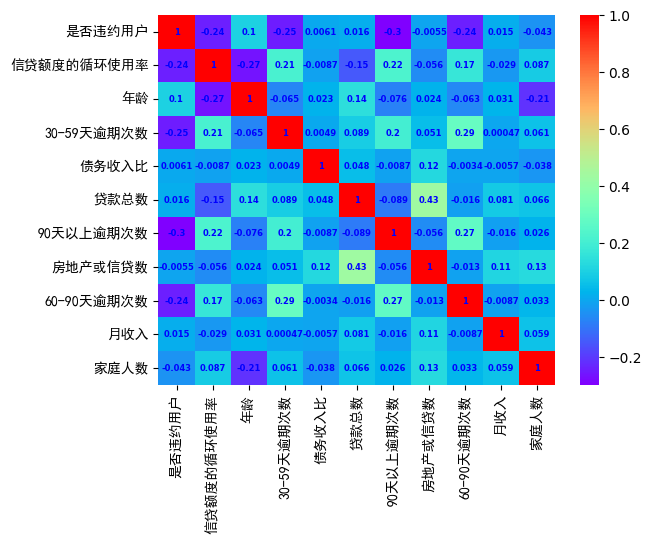

In [11]:
def heatmap_corr(df, prop):
    corr = df.corr()#计算各变量的相关性系数
    xticks = list(corr.index)#x轴标签
    yticks = list(corr.index)#y轴标签
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1)
    sns.heatmap(corr, annot=True, cmap='rainbow', ax=ax1, annot_kws={'size': 6, 'weight': 'bold', 'color': 'blue'})#绘制相关性系数热力图
    ax1.set_xticklabels(xticks, rotation=90, fontsize=10, fontproperties=prop)
    ax1.set_yticklabels(yticks, rotation=0, fontsize=10, fontproperties=prop)
    plt.show()

heatmap_corr(df, prop)

In [12]:
#保留要训练的特征
cols_to_remain = ['是否违约用户', '信贷额度的循环使用率_woe',
       '年龄_woe',  '债务收入比_woe','月收入_woe', '家庭人数_woe']

df_result = df_woe[cols_to_remain]
df_result.head()

,是否违约用户,信贷额度的循环使用率_woe,年龄_woe,债务收入比_woe,月收入_woe,家庭人数_woe
0,0,-1.049399,-0.269185,-0.159287,0.309220,-0.208172
1,1,-1.049399,-0.339805,0.147880,-0.299396,-0.107565
2,1,-1.049399,-0.339805,0.147880,-0.299396,0.152847
3,1,0.253603,-0.524064,0.147880,-0.299396,0.152847
4,1,-1.049399,-0.225172,0.147880,0.309220,0.152847


In [13]:
##模型训练
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# 特征和标签
X = df_result.drop(columns=['是否违约用户'])  # 特征（去除标签列）
y = df_result['是否违约用户']  # 标签（目标变量）

# 数据切分，8:2 的比例，随机种子设置为42，确保结果可重现
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 特征和标签
X = df_result.drop(columns=['是否违约用户'])  # 特征（去除标签列）
y = df_result['是否违约用户']  # 标签（目标变量）

# 数据切分，8:2 的比例，随机种子设置为42，确保结果可重现
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特征标准化（因为逻辑回归对特征尺度敏感）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 训练集标准化
X_test_scaled = scaler.transform(X_test)  # 测试集标准化

# 特征和标签
X = df_result.drop(columns=['是否违约用户'])  # 特征（去除标签列）
y = df_result['是否违约用户']  # 标签（目标变量）

# 数据切分，8:2 的比例，随机种子设置为42，确保结果可重现
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特征标准化（因为逻辑回归对特征尺度敏感）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 训练集标准化
X_test_scaled = scaler.transform(X_test)  # 测试集标准化

# 创建逻辑回归模型
model = LogisticRegression(solver='liblinear', verbose=1)  # 使用 'liblinear' 适合小数据集的求解器

# 训练模型
model.fit(X_train_scaled, y_train)



[LibLinear]iter  1 act 5.157e+04 pre 4.621e+04 delta 2.004e+00 f 8.119e+04 |g| 5.217e+04 CG   1
iter  2 act 5.380e+03 pre 4.493e+03 delta 2.004e+00 f 2.962e+04 |g| 1.105e+04 CG   2
iter  3 act 9.707e+02 pre 8.337e+02 delta 2.004e+00 f 2.424e+04 |g| 3.167e+03 CG   1
iter  4 act 9.879e+01 pre 9.185e+01 delta 2.004e+00 f 2.327e+04 |g| 8.316e+02 CG   2
iter  5 act 1.697e+00 pre 1.675e+00 delta 2.004e+00 f 2.317e+04 |g| 9.665e+01 CG   3
iter  6 act 8.816e-04 pre 8.814e-04 delta 2.004e+00 f 2.317e+04 |g| 2.399e+00 CG   3


LogisticRegression(solver='liblinear', verbose=1)

In [14]:
# 预测测试集
y_pred = model.predict(X_test_scaled)

# 模型评估
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# 输出评估结果
print(f"准确率: {accuracy:.4f}")
print("混淆矩阵:")
print(conf_matrix)
print("分类报告:")
print(class_report)

准确率: 0.9400
混淆矩阵:
[[    0  1756]
 [    0 27526]]
分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1756
           1       0.94      1.00      0.97     27526

    accuracy                           0.94     29282
   macro avg       0.47      0.50      0.48     29282
weighted avg       0.88      0.94      0.91     29282



AUC: 0.7759


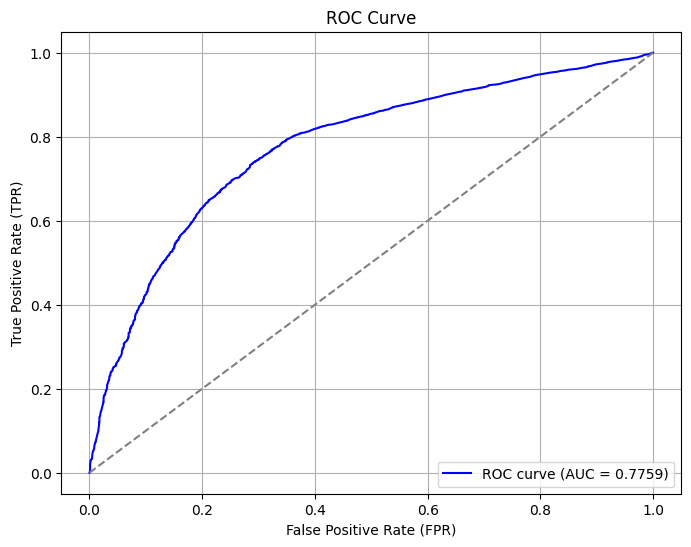

In [15]:
#查看AUC指标，并画出ROC曲线
# 计算 AUC
# 预测测试集的概率（注意这里是预测的概率，而不是分类结果）
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]  # 获取属于类 1（违约用户）的概率

auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc:.4f}")

# 计算 ROC 曲线
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 随机猜测的基准线
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

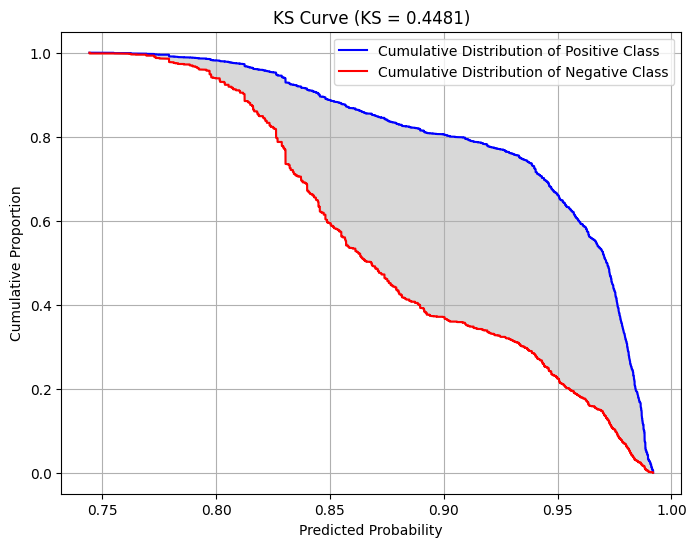

KS Value: 0.4481


In [16]:
#画出KS曲线
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 假设 df_result 已经包含 WOE 编码后的特征和标签
# 选择需要的列
cols_to_remain = ['是否违约用户', '信贷额度的循环使用率_woe', '年龄_woe', '债务收入比_woe', '月收入_woe', '家庭人数_woe']

# 获取需要的 DataFrame
df_result = df_woe[cols_to_remain]

# 特征和标签
X = df_result.drop(columns=['是否违约用户'])  # 特征
y = df_result['是否违约用户']  # 标签

# 数据切分，8:2 的比例，随机种子设置为42，确保结果可重现
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 创建逻辑回归模型
model = LogisticRegression(solver='liblinear')  # 使用 'liblinear' 适合小数据集的求解器

# 训练模型
model.fit(X_train_scaled, y_train)

# 预测测试集的概率（注意这里是预测的概率，而不是分类结果）
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]  # 获取属于类 1（违约用户）的概率

# 计算正类和负类的累积分布
# 将预测的概率从高到低排序
df_result = pd.DataFrame({'true_class': y_test, 'pred_prob': y_pred_prob})
df_result = df_result.sort_values(by='pred_prob', ascending=False)

# 计算正类和负类的累计分布
df_result['cum_good'] = (df_result['true_class'] == 1).cumsum() / (df_result['true_class'] == 1).sum()
df_result['cum_bad'] = (df_result['true_class'] == 0).cumsum() / (df_result['true_class'] == 0).sum()

# 计算 KS 值（正类和负类累计分布之间的最大差异）
df_result['ks'] = np.abs(df_result['cum_good'] - df_result['cum_bad'])
ks_value = df_result['ks'].max()

# 绘制 KS 曲线
plt.figure(figsize=(8, 6))
plt.plot(df_result['pred_prob'], df_result['cum_good'], label='Cumulative Distribution of Positive Class', color='b')
plt.plot(df_result['pred_prob'], df_result['cum_bad'], label='Cumulative Distribution of Negative Class', color='r')
plt.fill_between(df_result['pred_prob'], df_result['cum_good'], df_result['cum_bad'], color='gray', alpha=0.3)
plt.title(f'KS Curve (KS = {ks_value:.4f})')
plt.xlabel('Predicted Probability')
plt.ylabel('Cumulative Proportion')
plt.legend(loc='best')
plt.grid(True)
plt.show()

print(f"KS Value: {ks_value:.4f}")


In [19]:
#进行信用评分
# 查看各特征系数和截距
coefficients = model.coef_  # 系数
intercept = model.intercept_  # 截距

# 打印各特征的系数
coefficients_dict = dict()
print("特征系数：")
for feature, coef in zip(X.columns, coefficients[0]):
    print(f"{feature}: {coef:.4f}")
    coefficients_dict[feature] = coef

# 打印截距
print(f"\n模型截距：{intercept[0]:.4f}")

特征系数：
信贷额度的循环使用率_woe: 0.8203
年龄_woe: 0.2820
债务收入比_woe: 0.1350
月收入_woe: 0.1436
家庭人数_woe: 0.0684

模型截距：3.2104


In [35]:
def calc_credit_score(user_woe, intercept, coefficients):
    
    # 计算 log-odds
    log_odds = intercept  # 从截距开始
    for feature, coef in coefficients.items():
        log_odds += coef * user_woe[feature]
    
    # 计算预测概率 (sigmoid)
    probability = 1 / (1 + np.exp(-log_odds))
    
    # 假设我们使用以下参数进行信用评分转换：
    base_score = 600  # 基准分数
    scaling_factor = 20  # 缩放因子
    p_ref = 0.5  # 参考概率 (50%)
    
    # 计算参考的 log-odds
    log_odds_ref = np.log(p_ref / (1 - p_ref))
    
    # 计算用户的信用评分
    credit_score = base_score + scaling_factor * (log_odds - log_odds_ref)
    
    print(f"用户的信用评分是: {credit_score:.2f}")

def get_woe_value(x, woe_df):
    for i in range(len(woe_df)):
        if woe_df['min'][i] <= x <= woe_df['max'][i]:
            return woe_df['woe'][i]
    return np.nan  # 若没有匹配的区间，返回 NaN

user_ori = {
    '信贷额度的循环使用率': 0.0,
    '年龄': 60,
    '债务收入比': 1.0,
    '月收入': 10000.0,
    '家庭人数': 4
}
#将user的信息转化为woe编码
user_woe = dict()
for feature_name in user_ori.keys():
    x = user_ori[feature_name]
    woe_df = feature_value_woe_map[feature_name]
    woe_value = get_woe_value(x, woe_df)
    user_woe[feature_name+"_woe"] = woe_value
print(user_woe)
    
calc_credit_score(user_woe, intercept[0], coefficients_dict)

{'信贷额度的循环使用率_woe': np.float64(1.2026154585296331), '年龄_woe': np.float64(0.4663728476668635), '债务收入比_woe': np.float64(-0.15928668928719267), '月收入_woe': np.float64(0.30922022647589886), '家庭人数_woe': np.float64(-0.359945420117473)}
用户的信用评分是: 686.53
